In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.plotting import plot_pca_correlation_graph
import numpy as np
import plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from scipy import stats
from scipy.stats import zscore
import requests
import seaborn as sns
from matplotlib import colors as mcolors
from sklearn.manifold import TSNE
import warnings
import matplotlib.cbook
from sklearn.svm import SVC

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
# read each dataset to dataframe
Unemployment = pd.read_csv('./Eco_Data/Unemployment Rate .csv', skiprows= [0,1,2,3,4])
Unemployment = Unemployment.rename({'Data': 'Unemployment_Rate'}, axis=1)

Poverty = pd.read_csv('./Eco_Data/Poverty.csv', skiprows= [0,1,2,3,4])
Poverty = Poverty.rename({'Data': 'Poverty'}, axis=1)

Employment_Population = pd.read_csv('./Eco_Data/Employment Population Ratio.csv', skiprows= [0,1,2,3,4])
Employment_Population = Employment_Population.rename({'Data': 'Employment_Population'}, axis=1)

Uninsured = pd.read_csv('./Health/Uninsured.csv', skiprows= [0,1,2,3,4])
Uninsured = Uninsured.rename({'Data': 'Uninsured'}, axis=1)

Family_Income = pd.read_csv('./Eco_Data/Family Income.csv', skiprows= [0,1,2,3,4])
Family_Income = Family_Income.rename({'Data': 'Family_Income'}, axis=1)

Educational_Attainment = pd.read_csv('./Eco_Data/Educational Attainment.csv', skiprows= [0,1,2,3,4])
Educational_Attainment = Educational_Attainment.rename({'Data': 'Educational_Attainment'}, axis=1)




In [3]:
Unemployment = Unemployment[(Unemployment['Location'] != 'New York City' )]
Poverty = Poverty[(Poverty['Location'] != 'New York City' )]
Employment_Population = Employment_Population[(Employment_Population['Location'] != 'New York City' )]
Uninsured = Uninsured[(Uninsured['Location'] != 'New York City' )]
Family_Income = Family_Income[(Family_Income['Location'] != 'New York City' )]
Educational_Attainment = Educational_Attainment[(Educational_Attainment['Location'] != 'New York City' )]

# find the common colunm and get the proper infomation 
Poverty = Poverty[(Poverty['DataFormat'] == 'Number' )]

# All age
Uninsured = Uninsured[(Uninsured['Age Group'] == 'All Ages' )&
                      (Uninsured['DataFormat'] == 'Number' )]
# Income Level under $15,000
Family_Income = Family_Income[(Family_Income['Income Level'] == 'Under $15,000' ) &
                             (Family_Income['DataFormat'] == 'Number' )]
# Less than High School Degree 
Educational_Attainment = Educational_Attainment[(Educational_Attainment['Education Level'] == 
                                                 'Less than High School Degree') &
                                                (Educational_Attainment['DataFormat'] == 'Number' )]
Educational_Attainment.head()

# merge the data to one dataframe
df = pd.merge(Unemployment, Poverty,on = [ "TimeFrame","Fips","Location"] )
df = pd.merge(df, Employment_Population,on = [ "TimeFrame","Fips","Location"] )
df = pd.merge(df, Uninsured,on = [ "TimeFrame","Fips","Location"] )
df = pd.merge(df, Family_Income,on = [ "TimeFrame","Fips","Location"] )
df = pd.merge(df, Educational_Attainment,on = [ "TimeFrame","Fips","Location"] )
df = df[(df['Location'] != 'Bronx' ) &
                            (df['Location'] != 'Brooklyn' )&
                            (df['Location'] != 'Manhattan' )&
                            (df['Location'] != 'Queens')& 
                            (df['Location'] != 'Staten Island')]





In [4]:
#Aplly Z-score
df1 = df
df1 = df1[df1.columns[df1.columns.isin(['Unemployment_Rate', 'Poverty','Employment_Population','Uninsured',
                                        'Family_Income','Educational_Attainment'])]]

df1 = df1.dropna(how='any') # drop nan entries
df1 = df1[(np.abs(stats.zscore(df1)) < 3).all(axis=1)] # remove outliers
df1 = df1.apply(zscore) # Normalization
df['Unemployment_Rate'] = df1['Unemployment_Rate']
df['Poverty'] = df1['Poverty']
df['Employment_Population'] = df1['Employment_Population']
df['Uninsured'] = df1['Uninsured']
df['Family_Income'] = df1['Family_Income']
df['Educational_Attainment'] = df1['Educational_Attainment']
df_test = df

# 0-11 bronx
# 12-23 Manhattan
# 24-26 Staten Island
# 27-44 Brooklyn
# 45-58 Queens

CD_Name = df_test[df_test['TimeFrame'] == 2008]['Location'].values.tolist()


Borough = list()

for i in range(59):
    if i < 12:
        Borough.append('Bronx')
    elif i > 11 and i < 24:
         Borough.append('Manhattan')
    elif i > 23 and i < 27:
         Borough.append('Staten Island')
    elif i > 26 and i < 45:
         Borough.append('Brooklyn')
    else:
        Borough.append('Queens')

Location_ = df_test['Location'].values.tolist()
len_L = len(Location_)
CD_Boro = {CD_Name[i]: Borough[i] for i in range(len(CD_Name))}
Get_Borough = [None] * len_L
for x in range(len_L):
    for i, n in CD_Boro.items():
        if Location_[x] in i:
            Get_Borough[x] = n

    

df_test['Borough'] = Get_Borough

df = df_test

cd =[ 'Astoria','Q01','Battery Park/Tribeca', 'M01','Bay Ridge','K10','Bayside','Q11',
'Bedford Park','B07','Bedford Stuyvesant' ,'K03','Bensonhurst','K11','Borough Park','K12',
'Brownsville','K16','Bushwick','K04', 'Canarsie','K18','Central Harlem','M10',
'Chelsea/Clinton','M04','Concourse/Highbridge','B04','Coney Island','K13','Crown Heights North','K08',
'Crown Heights South', 'K09', 'East Flatbush', 'K17','East Harlem', 'M11','East New York','K05',
'East Tremont', 'B06','Elmhurst/Corona', 'Q04','Flatbush/Midwood', 'K14', 'Flushing', 'Q07', 
'Fort Greene/Brooklyn Hts', 'K02','Fresh Meadows/Briarwood', 'Q08','Greenwich Village', 'M02', 'Howard Beach',
'Q10', 'Hunts Point', 'B02', 'Jackson Heights', 'Q03', 'Jamaica/St. Albans','Q12', 'Lower East Side', 'M03',
'Manhattanville', 'M09','Midtown Business District', 'M05', 'Morrisania', 'B03', 'Mott Haven', 'B01', 
'Murray Hill/Stuyvesant', 'M06','Park Slope', 'K06', 'Pelham Parkway', 'B11', 'Queens Village', 
'Q13', 'Rego Park/Forest Hills', 'Q06','Ridgewood/Glendale', 'Q05', 'Riverdale', 'B08', 'Sheepshead Bay', 
'K15', 'South Beach','S02','St. George', 'S01', 'Sunnyside/Woodside', 'Q02', 'Sunset Park','K07', 
'The Rockaways', 'Q14','Throgs Neck', 'B10', 'Tottenville', 'S03', 'Unionport/Soundview', 'B09', 
'University Heights', 'B05','Upper East Side', 'M08', 'Upper West Side', 'M07', 'Washington Heights', 
'M12', 'Williamsbridge', 'B12','Williamsburg/Greenpoint', 'K01', 'Woodhaven', 'Q09']
CD_Name = list()
CD_Num = list()
i = 0
while i < len(cd):
    CD_Name.append(cd[i])
    i = i + 1
    CD_Num.append(cd[i])
    i += 1
cd = dict(zip(CD_Name, CD_Num))
df['Boro_CD'] = df['Location'].map(cd)

df['Boro_CD'] = df['Boro_CD'].str.replace('B','1')
df['Boro_CD'] = df['Boro_CD'].str.replace('K','2')
df['Boro_CD'] = df['Boro_CD'].str.replace('M','3')
df['Boro_CD'] = df['Boro_CD'].str.replace('Q','4')
df['Boro_CD'] = df['Boro_CD'].str.replace('S','5')




In [5]:
def pca_(df):
        features = ['Unemployment_Rate','Poverty','Employment_Population','Uninsured',
                   'Family_Income','Educational_Attainment']
   
        
        # Set up the target or y for LDA training 
        # y = df.loc[:,['TimeFrame']].values # change to location
        y = df.loc[:,['Borough']].values # change to location
     
        # Target name
        # targets = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
        targets = ['Bronx','Brooklyn' ,'Manhattan' ,'Queens', 'Staten Island']
#         targets = Location_name
        for n in range(0,len(y)):
            for i in range(len(targets)):
                if y[n] == targets[i]:
                    y[n] = targets.index(targets[i])

        
        
        # set to contiguous flattened array
        y = y.ravel()
        # set the data type to integer
        y = y.astype('int')
      
        # Separate the features from the dataset
        X = df.loc[:,features].values
       
       
        target_names = targets
        # Principal component analysis
        pca = PCA(n_components=1)
        X_r = pca.fit(X).transform(X)
        df['X_r'] = X_r
        df['y'] = y
        data = [df["y"], df["X_r"]]

        headers = ["y", "X_r"]

        df_prepare = pd.concat(data, axis=1, keys=headers)
        df_prepare.reset_index(drop=True)
        
     
        return df_prepare
     
        
    




In [22]:
df = df.dropna()
df = df.reset_index(drop=True)
# df_2010 = df[(df['TimeFrame'] == 2010)]
# df_2008 = df[(df['TimeFrame'] == 2008)]
# df_2017 = df[(df['TimeFrame'] == 2017)]
# df_2018 = df[(df['TimeFrame'] == 2018)]
df_2019 = df[(df['TimeFrame'] == 2019)]
df_2019.count()


Location                  58
TimeFrame                 58
DataFormat_x              58
Unemployment_Rate         58
Fips                      58
DataFormat_y              58
Poverty                   58
DataFormat_x              58
Employment_Population     58
Age Group                 58
DataFormat_y              58
Uninsured                 58
Income Level              58
DataFormat_x              58
Family_Income             58
Education Level           58
DataFormat_y              58
Educational_Attainment    58
Borough                   58
Boro_CD                   58
dtype: int64

In [8]:

df_2019 =pca_(df_2019)



In [9]:
# frames = [df_2017, df_2018]
  
# df_pre = pd.concat(frames)
# frames = [df_pre, df_2019]
# df_pre = pd.concat(frames)
df_pre = df_2019
df_pre.head()

,y,X_r
628,2,3.086043
629,2,2.933158
630,2,-2.313062
631,2,2.400605
632,2,2.898045


Coefficients: 
 [0.24479699]
Mean squared error: 3.84
Coefficient of determination: -4.28
[[-2.33180687]
 [ 0.57614146]
 [ 0.20451293]
 [ 1.02953666]
 [ 1.26954686]
 [-1.04448374]
 [ 0.32046468]
 [ 0.92849087]
 [ 1.77200183]
 [-2.97469468]
 [ 0.22235594]
 [ 0.43890783]
 [ 1.13817208]
 [ 1.47389302]
 [-1.15389417]
 [ 0.49911215]
 [-0.50173212]
 [ 0.00739186]
 [ 1.02461651]
 [ 1.95175467]]
[0.43411058 1.14596759 1.05499404 1.25695737 1.31571114 0.74924341
 1.08337868 1.23222166 1.43871061 0.27673358 1.05936196 1.11237321
 1.28355099 1.36573447 0.72246007 1.12711104 0.88210738 1.0067394
 1.25575293 1.48271356]


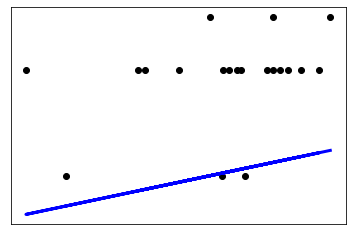

In [20]:


# Load the diabetes dataset
X = df_pre['X_r']
y = df_pre['y']

X = X.values.reshape(-1,1)
# Use only one feature


# Split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# Split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())
print(X_test)
print(y_pred)
plt.show()

In [12]:
from sklearn import datasets
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
#
# Load the Boston Data Set
#
X = df_pre['X_r']
y = df_pre['y']
X = X.values.reshape(-1,1)
#
# Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#
from sklearn.preprocessing import StandardScaler
sc_y = StandardScaler()
sc_x = StandardScaler()
y_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
X_train_std = sc_x.fit_transform(X_train)
X_test_std = sc_x.transform(X_test)
y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()





<ipython-input-12-356ee034fb49>:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
<ipython-input-12-356ee034fb49>:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()


In [13]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
alpha = np.linspace(0.01,0.4,10)
r2_train =[]
r2_test =[]
norm = []
alpha = np.linspace(0.01,0.4,10)
for i in range(10):
    lasso = Lasso(alpha = alpha[i])
    lasso.fit(X_train_std,y_train_std)
    y_train_std = lasso.predict(X_train_std)
    y_test_std = lasso.predict(X_test_std)
    r2_train = np.append(r2_train,
              r2_score(y_train,sc_y.inverse_transform(y_train_std)))
    r2_test = np.append(r2_test,
              r2_score(y_test,sc_y.inverse_transform(y_test_std)))
    norm = np.append(norm,np.linalg.norm(lasso.coef_))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/li

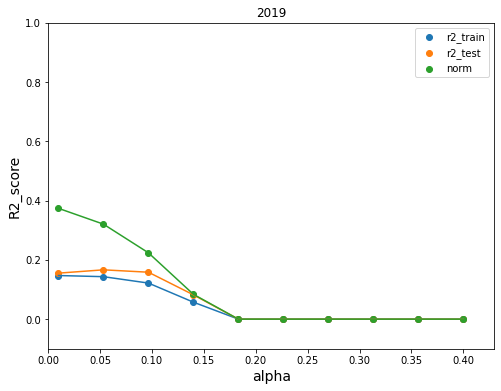

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(alpha,r2_train,label='r2_train')
plt.plot(alpha,r2_train)
plt.scatter(alpha,r2_test,label='r2_test')
plt.plot(alpha,r2_test)
plt.scatter(alpha,norm,label = 'norm')
plt.plot(alpha,norm)
plt.ylim(-0.1,1)
plt.xlim(0,.43)
plt.xlabel('alpha', size = 14)
plt.ylabel('R2_score',size = 14)
plt.title("2019")
plt.legend()
plt.show()

In [15]:
from sklearn import tree



In [16]:
df = df[(df['TimeFrame'] == 2019)]
features = ['Unemployment_Rate','Poverty','Employment_Population','Uninsured',
                   'Family_Income','Educational_Attainment']

X = df[features]
y = df.loc[:,['Borough']].values # change to location
     
        # Target name
        # targets = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
targets = ['Bronx','Brooklyn' ,'Manhattan' ,'Queens', 'Staten Island']
#         targets = Location_name
for n in range(0,len(y)):
    for i in range(len(targets)):
        if y[n] == targets[i]:
            y[n] = targets.index(targets[i])

        
        
        # set to contiguous flattened array
y = y.ravel()
        # set the data type to integer
y = y.astype('int')

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)


[Text(233.1642857142857, 201.90857142857143, 'X[0] <= -0.464\ngini = 0.764\nsamples = 58\nvalue = [12, 18, 11, 14, 3]'),
 Text(155.44285714285715, 170.84571428571428, 'X[3] <= -0.57\ngini = 0.717\nsamples = 46\nvalue = [2, 17, 10, 14, 3]'),
 Text(95.65714285714286, 139.78285714285715, 'X[4] <= -1.049\ngini = 0.683\nsamples = 29\nvalue = [2, 13, 9, 3, 2]'),
 Text(47.82857142857143, 108.72, 'X[2] <= 0.928\ngini = 0.653\nsamples = 12\nvalue = [0, 1, 6, 3, 2]'),
 Text(23.914285714285715, 77.65714285714284, 'X[0] <= -1.283\ngini = 0.48\nsamples = 5\nvalue = [0, 0, 0, 3, 2]'),
 Text(11.957142857142857, 46.59428571428572, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 0, 0, 2]'),
 Text(35.871428571428574, 46.59428571428572, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 0, 3, 0]'),
 Text(71.74285714285715, 77.65714285714284, 'X[2] <= 2.214\ngini = 0.245\nsamples = 7\nvalue = [0, 1, 6, 0, 0]'),
 Text(59.785714285714285, 46.59428571428572, 'gini = 0.0\nsamples = 6\nvalue = [0, 0, 6, 0, 0]'),
 Text(83.7, 46

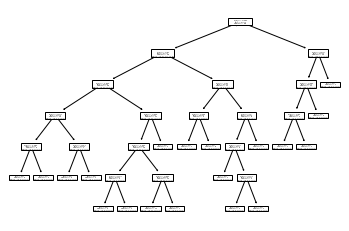

In [17]:
tree.plot_tree(clf) 

In [18]:
from six import StringIO
from IPython.display import Image  
import pydotplus
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 


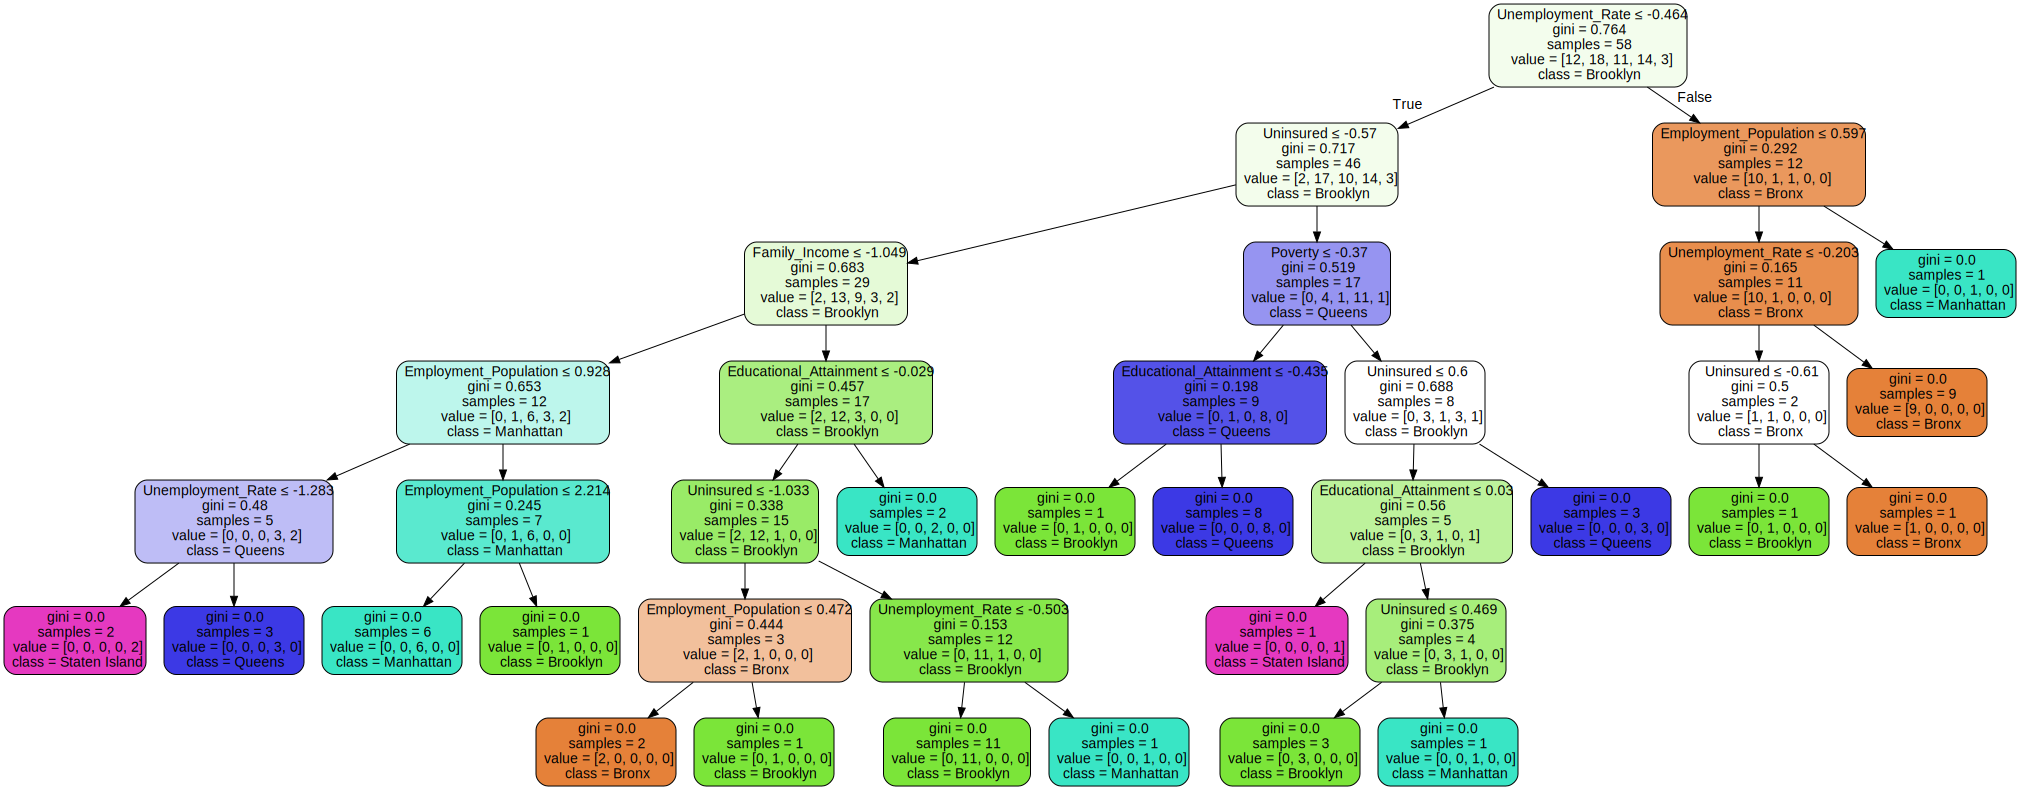

In [19]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=features,  
                      class_names=targets,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
# principal component regression (PCR) is a regression analysis
# Cross validation
# Boosting
# XGBOsst
# XGBOOST